# Использование моделей МО для определения региона, в котором добыча нефти принесёт наибольшую прибыль

Компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

**Шаги для выбора локации:**
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Данные геологоразведки трёх регионов находятся в файлах: 
/datasets/geo_data_0.csv. 
/datasets/geo_data_1.csv. 
/datasets/geo_data_2.csv. 

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import make_scorer 

## Загрузка и подготовка данных

### Загрузка и предобработка данных

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
geo_data_0.info()
geo_data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_data_1.info()
geo_data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
geo_data_2.info()
geo_data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
#Проверка пропусков
print('Количество пропусков: \n', geo_data_0.isna().sum(), '\n')

#Поиск дубликатов и их удаление
print('Количество дубликатов до форматирования:', geo_data_0.duplicated().sum())

Количество пропусков: 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Количество дубликатов до форматирования: 0


In [7]:
#Проверка пропусков
print('Количество пропусков: \n', geo_data_1.isna().sum(), '\n')

#Поиск дубликатов и их удаление
print('Количество дубликатов до форматирования:', geo_data_1.duplicated().sum())

Количество пропусков: 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Количество дубликатов до форматирования: 0


In [8]:
#Проверка пропусков
print('Количество пропусков: \n', geo_data_2.isna().sum(), '\n')

#Поиск дубликатов и их удаление
print('Количество дубликатов до форматирования:', geo_data_2.duplicated().sum())

Количество пропусков: 
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 

Количество дубликатов до форматирования: 0


**Вывод:** Данные соответствуют описанию задачи. Названия и типы всех столбцов соответствуют стандартам оформления данных. Пропуско и дубликатов не выявлено.

### Исследовательский анализ данных

In [9]:
def num_research(data):
    num_cols = data.select_dtypes(include=['number']).columns
    num_plots = len(num_cols)
    
    plt.figure(figsize=(10, 5 * num_plots))
    for i, col in enumerate(num_cols):
        # Гистограмма
        plt.subplot(num_plots, 2, 2*i + 1)
        data[col].hist(bins=10)
        plt.title(f'Hist {col}')
        plt.xlabel(col)

        # Ящик
        plt.subplot(num_plots, 2, 2*i + 2)
        data.boxplot(column=col)
        plt.title(f'Box {col}')
    plt.tight_layout()
    plt.show()

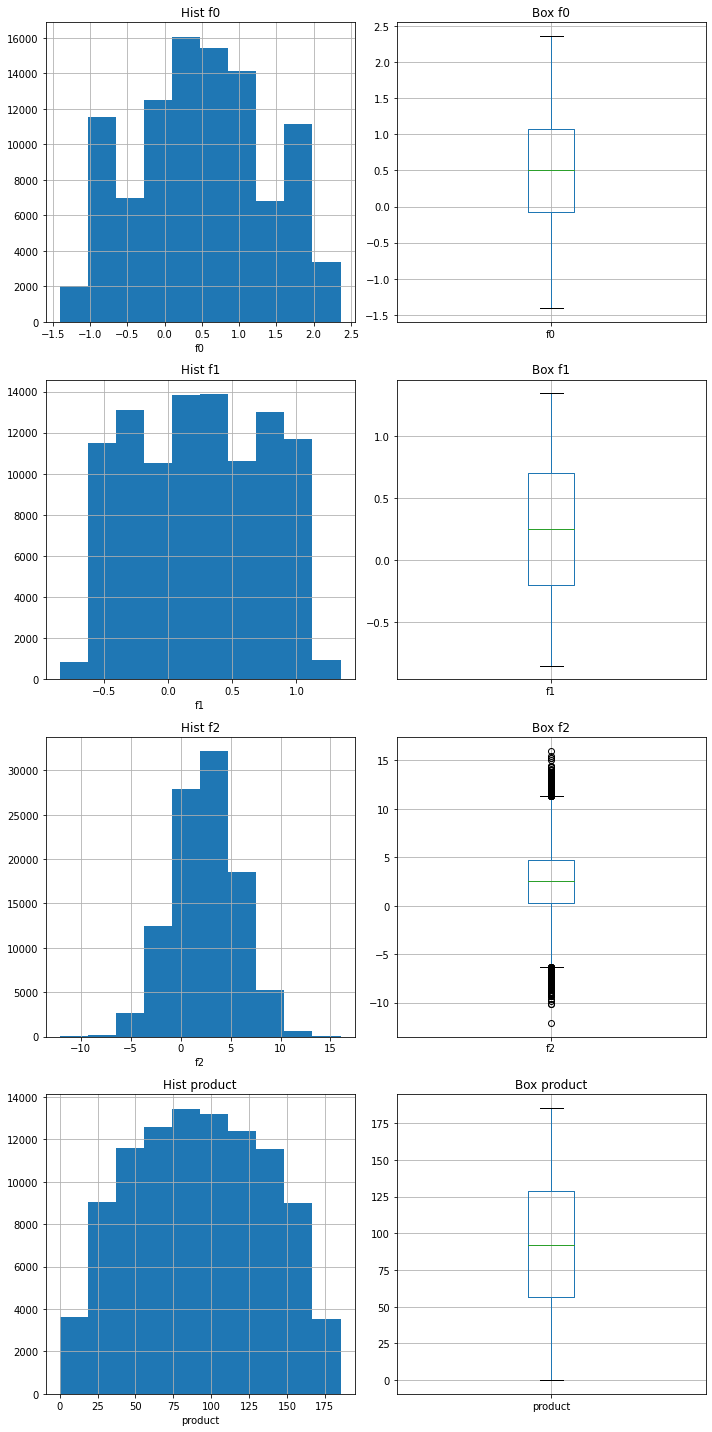

In [10]:
num_research(geo_data_0)

<AxesSubplot:>

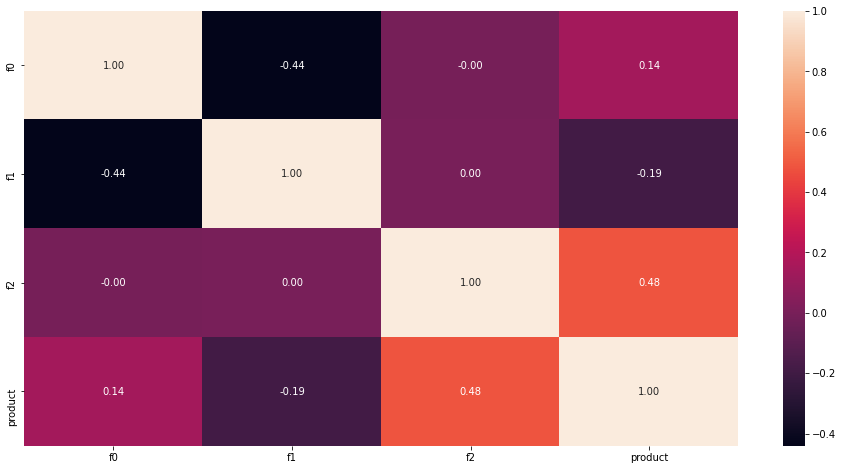

In [11]:
plt.figure(figsize=(16, 8))
fmcor = geo_data_0.drop('id', axis=1).corr()
sns.heatmap(fmcor, annot=True, fmt='.2f')

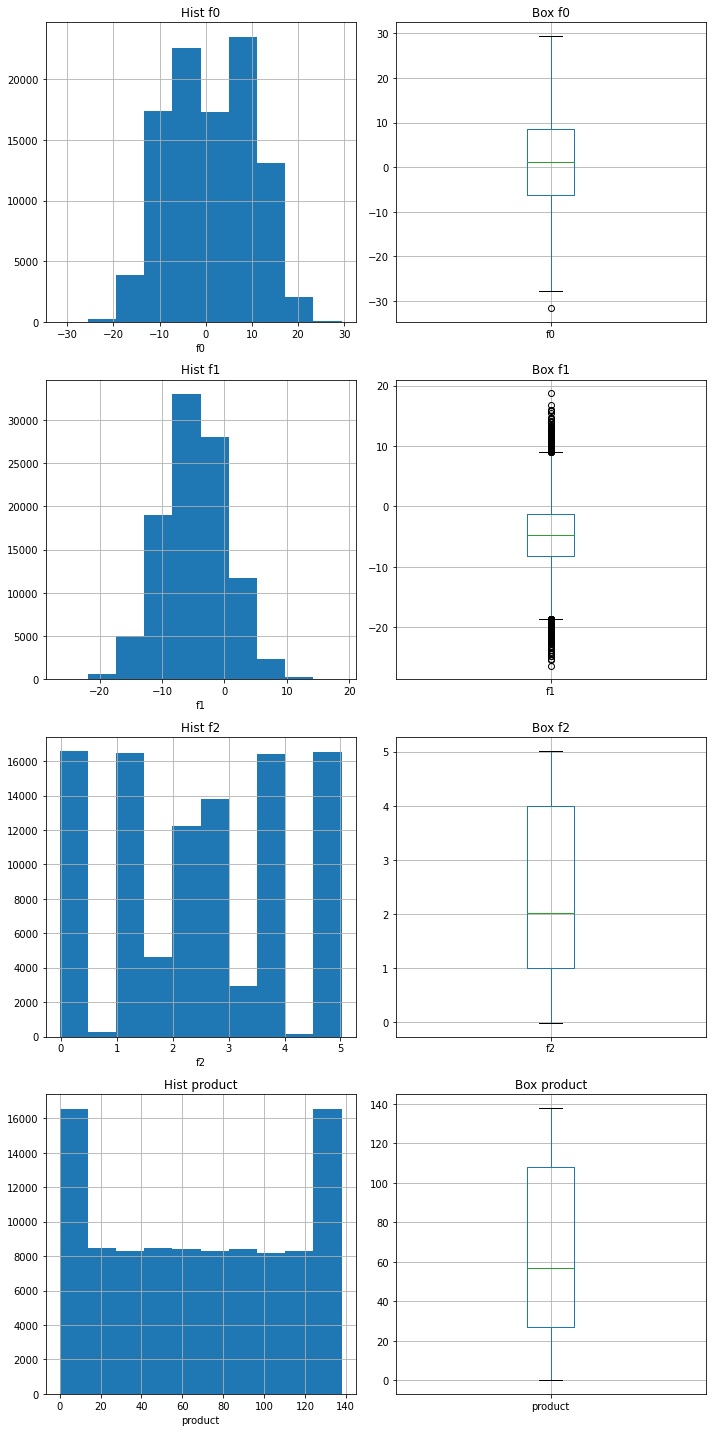

In [12]:
num_research(geo_data_1)

<AxesSubplot:>

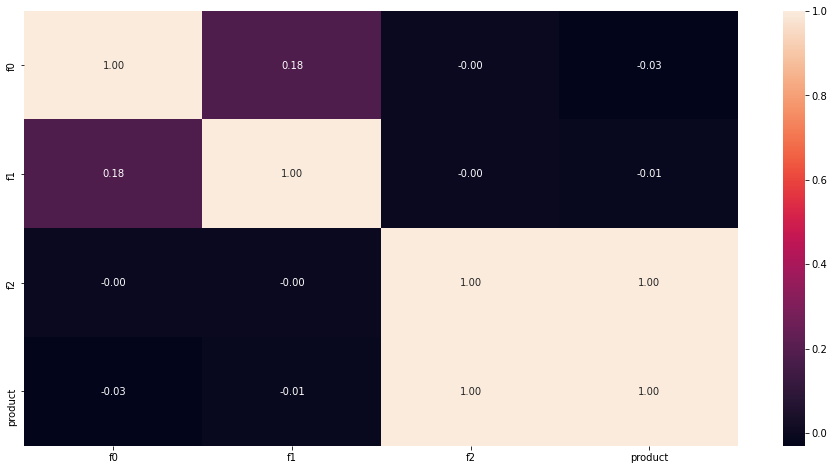

In [13]:
plt.figure(figsize=(16, 8))
fmcor = geo_data_1.drop('id', axis=1).corr()
sns.heatmap(fmcor, annot=True, fmt='.2f')

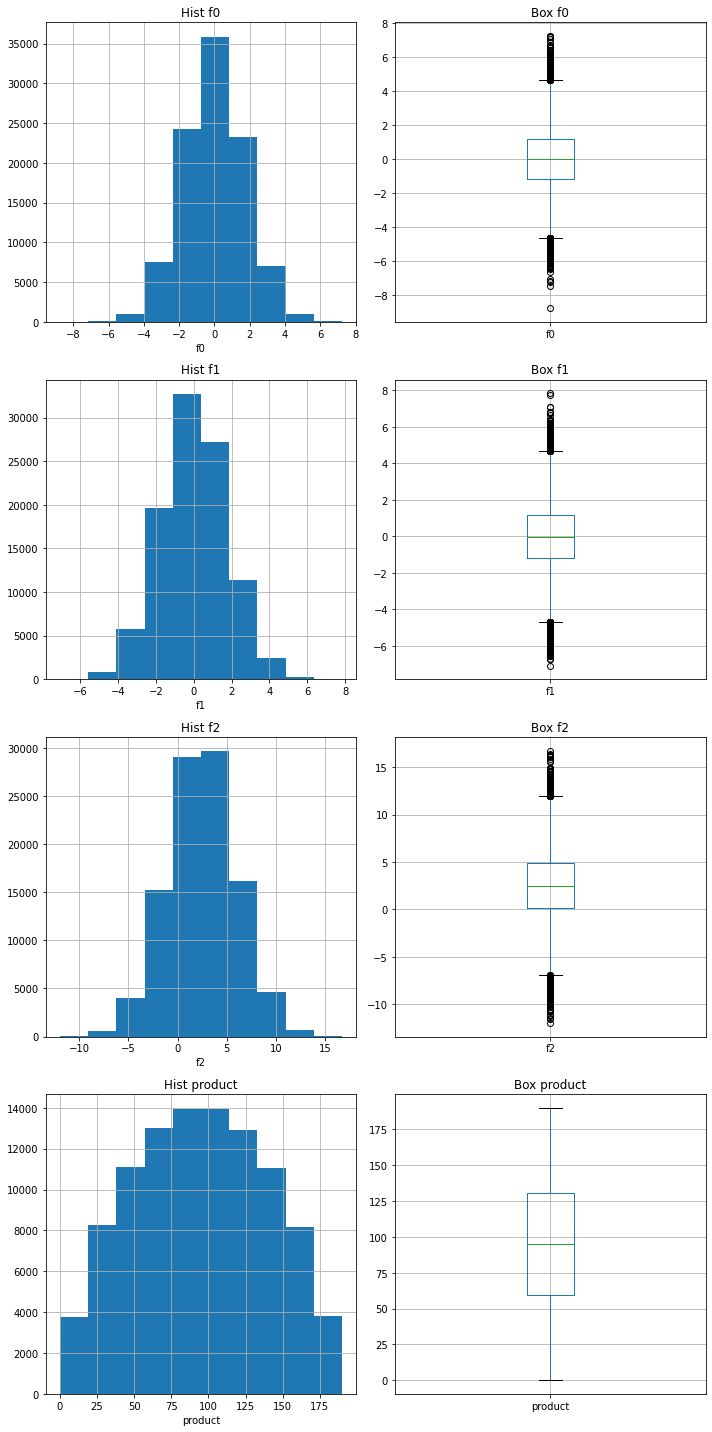

In [14]:
num_research(geo_data_2)

<AxesSubplot:>

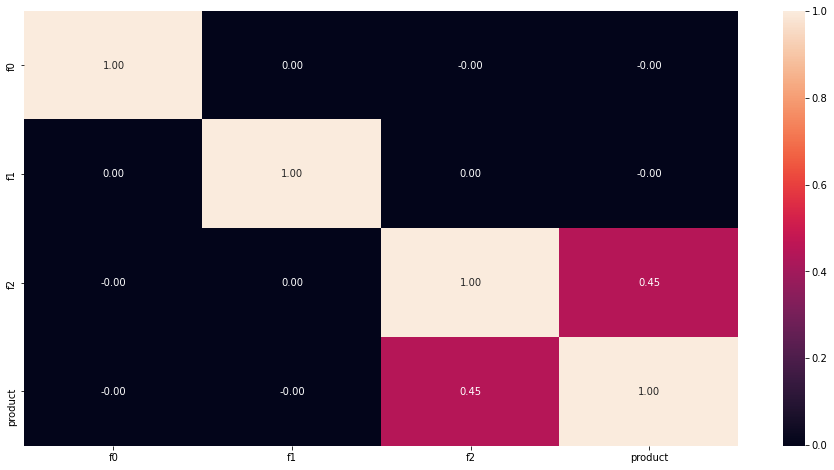

In [15]:
plt.figure(figsize=(16, 8))
fmcor = geo_data_2.drop('id', axis=1).corr()
sns.heatmap(fmcor, annot=True, fmt='.2f')

**Вывод:** В данных присутсвуют выбросы, но так как неизвестно что это за признаки, то не представляется возможным избавитья от них.

### Подготовка данных

In [16]:
X_0 = geo_data_0.drop(['product', 'id'], axis=1)
y_0 = geo_data_0['product']

X_1 = geo_data_1.drop(['product', 'id'], axis=1)
y_1 = geo_data_1['product']

X_2 = geo_data_2.drop(['product', 'id'], axis=1)
y_2 = geo_data_2['product']

In [17]:
num_columns = ['f0', 'f1', 'f2']

data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_columns)], 
    remainder='passthrough'
)

## Обучение и проверка модели

In [18]:
# Метрика
def rmse_func(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse = make_scorer(rmse_func, greater_is_better=False)

In [19]:
RANDOM_STATE = 42

X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(
    X_0, y_0, test_size=0.25, random_state=RANDOM_STATE)

In [20]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(
    X_1, y_1, test_size=0.25, random_state=RANDOM_STATE)

In [21]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
    X_2, y_2, test_size=0.25, random_state=RANDOM_STATE)

In [22]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

### Обучение и проверка модели на первом месторождении

In [23]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=rmse,
    random_state=RANDOM_STATE,
    n_iter=3,
    n_jobs=-1
)
randomized_search.fit(X_train_0, y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['f0',
                                                                                'f1',
                                                                                'f2'])])),
                                             ('models', LinearRegression())]),
                   n_iter=3, n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                            

In [24]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на cv-выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели на cv-выборке: -37.67200536313506


In [25]:
#Расчеты
y_pred_0 = randomized_search.predict(X_valid_0)
print(f'Средний запас валидационного сырья в нулевом регионе: {y_valid_0.mean()}')
print(f'Средний запас предсказанного сырья в нулевом регионе: {y_pred_0.mean()}')
print(f'Метрика RMSE нулевого региона: {rmse_func(y_valid_0, y_pred_0)}')

Средний запас валидационного сырья в нулевом регионе: 92.32595637084387
Средний запас предсказанного сырья в нулевом регионе: 92.39879990657768
Метрика RMSE нулевого региона: 37.75660035026169


### Обучение и проверка модели на втором месторождении

In [26]:
randomized_search_1 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=rmse,
    random_state=RANDOM_STATE,
    n_iter=3,
    n_jobs=-1
)
randomized_search_1.fit(X_train_1, y_train_1)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['f0',
                                                                                'f1',
                                                                                'f2'])])),
                                             ('models', LinearRegression())]),
                   n_iter=3, n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                            

In [27]:
print('Лучшая модель и её параметры:\n\n', randomized_search_1.best_estimator_)
print ('Метрика лучшей модели на cv-выборке:', randomized_search_1.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели на cv-выборке: -0.8904559629285671


In [28]:
#Расчеты
y_pred_1 = randomized_search_1.predict(X_valid_1)
print(f'Средний запас валидационного сырья в первом регионе: {y_valid_1.mean()}')
print(f'Средний запас предсказанного сырья в первом регионе: {y_pred_1.mean()}')
print(f'Метрика RMSE первого региона: {rmse_func(y_valid_1, y_pred_1)}')

Средний запас валидационного сырья в первом регионе: 68.72538074722745
Средний запас предсказанного сырья в первом регионе: 68.7128780391376
Метрика RMSE первого региона: 0.8902801001028846


### Обучение и проверка модели на третьем месторождении

In [29]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=rmse,
    random_state=RANDOM_STATE,
    n_iter=3,
    n_jobs=-1
)
randomized_search_2.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               MinMaxScaler(),
                                                                               ['f0',
                                                                                'f1',
                                                                                'f2'])])),
                                             ('models', LinearRegression())]),
                   n_iter=3, n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                            

In [30]:
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print('Метрика лучшей модели на cv-выборке:', randomized_search_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['f0', 'f1', 'f2'])])),
                ('models', LinearRegression())])
Метрика лучшей модели на cv-выборке: -40.02698159997838


In [31]:
#Расчеты
y_pred_2 = randomized_search_2.predict(X_valid_2)
print(f'Средний запас валидационного сырья во втором регионе: {y_valid_2.mean()}')
print(f'Средний запас предсказанного сырья во втором регионе: {y_pred_2.mean()}')
print(f'Метрика RMSE второго региона: {rmse_func(y_valid_2, y_pred_2)}')

Средний запас валидационного сырья во втором регионе: 95.15099907171961
Средний запас предсказанного сырья во втором регионе: 94.77102387765939
Метрика RMSE второго региона: 40.145872311342174


**Вывод:** 
- Нулевой регион:
    - Средний запас валидационного сырья: 92.33 тыс. баррелей.
    - Средний запас предсказанного сырья: 92.40 тыс. баррелей.
    - RMSE: 37.76 тыс. баррелей.

В нулевом регионе модель предсказывает средний запас сырья довольно близко к фактическому, но метрика RMSE показывает достаточно высокую ошибку. Это указывает на то, что предсказания модели в этом регионе могут сильно варьироваться и не всегда точно отражают фактические данные.


- Первый регион:
    - Средний запас валидационного сырья: 68.73 тыс. баррелей.
    - Средний запас предсказанного сырья: 68.71 тыс. баррелей.
    - RMSE: 0.89 тыс. баррелей.

В первом регионе модель показывает наилучшие результаты. Средние значения предсказанного и фактического сырья практически совпадают, а метрика RMSE очень низкая, что говорит о высокой точности модели в этом регионе.

- Второй регион:
    - Средний запас валидационного сырья: 95.15 тыс. баррелей.
    - Средний запас предсказанного сырья: 94.77 тыс. баррелей.
    - RMSE: 40.15 тыс. баррелей.

Во втором регионе модель тоже показывает достаточно близкие к фактическим значениям предсказанного среднего запаса, но ошибка RMSE довольно велика.

- Общий вывод:
    - Первый регион выделяется как наиболее стабильный и предсказуемый, с минимальной ошибкой RMSE. Модель в этом регионе работает очень точно, что делает его наилучшим кандидатом для разработки.
    - Нулевой регион также показывает неплохие результаты, но высокая RMSE указывает на большую неопределенность в предсказаниях.
    - Второй регион имеет самые высокие средние запасы, но значительная ошибка RMSE говорит о больших рисках при разработке.
    
Рекомендация: Первый регион кажется наиболее предпочтительным для бурения с точки зрения стабильности предсказаний модели.

## Подготовка к расчёту прибыли

In [32]:
MEAN_PRED_PRODUCT_0 = 92.40 
MEAN_PRED_PRODUCT_1 = 68.71  
MEAN_PRED_PRODUCT_2 = 94.77 

BUDGET = 10_000_000_000
COUNT = 200
BAR_PRICE = 450_000

In [33]:
def min_profit(budget=10_000_000_000, count=200, bar_price=450_000):
    return budget / (count * bar_price)
print(f'Объём сырья для безубыточной разработки новой скважины: {min_profit():.2f}')

Объём сырья для безубыточной разработки новой скважины: 111.11


**Вывод:** 

- Нулевой регион: Средний предсказанный запас сырья (92.40 тыс. баррелей) приближен к необходимому объёму. Если предсказанный запас выше необходимого уровня, регион может быть прибыльным, но из-за близости значений есть вероятность, что он может оказаться на грани рентабельности.

- Первый регион: Средний предсказанный запас сырья (68.71 тыс. баррелей) значительно ниже необходимого уровня. Этот регион с высокой вероятностью будет убыточным, так как запасы недостаточны для покрытия затрат.

- Второй регион: Средний предсказанный запас сырья (94.77 тыс. баррелей) также близок к достаточному объёму, но немного выше. Регион может оказаться прибыльным, однако, как и в случае с нулевым регионом, результаты могут быть на грани рентабельности.

Рекомендация: Первый регион возможно придется исключить из сравнения из-за низких запасов сырья. Нулевой и второй регионы можно рассматривать для дальнейшей разработки, но необходимо будет провести дополнительные расчёты.

## Расчёт прибыли и рисков 

In [34]:
y_valid_0.reset_index(drop=True, inplace=True)
y_pred_0 = pd.Series(y_pred_0)
y_vp_0 = pd.DataFrame()
y_vp_0['valid'] = y_valid_0
y_vp_0['pred'] = y_pred_0

In [35]:
y_valid_1.reset_index(drop=True, inplace=True)
y_pred_1 = pd.Series(y_pred_1)
y_vp_1 = pd.DataFrame()
y_vp_1['valid'] = y_valid_1
y_vp_1['pred'] = y_pred_1

In [36]:
y_valid_2.reset_index(drop=True, inplace=True)
y_pred_2 = pd.Series(y_pred_2)
y_vp_2 = pd.DataFrame()
y_vp_2['valid'] = y_valid_2
y_vp_2['pred'] = y_pred_2

In [37]:
def profit(y_vp, budget=10_000_000_000, count=200, bar_price=450_000):
    y_vp_sorted = y_vp.nlargest(count, 'pred')
    total = y_vp_sorted['valid'].sum()
    profit_value = total * bar_price - budget
    
    return profit_value

In [38]:
print(f'Прибыль для региона 0: {profit(y_vp=y_vp_0):.2f} рублей')
print(f'Прибыль для региона 1: {profit(y_vp=y_vp_1):.2f} рублей')
print(f'Прибыль для региона 2: {profit(y_vp=y_vp_2):.2f} рублей')

Прибыль для региона 0: 3359141114.46 рублей
Прибыль для региона 1: 2415086696.68 рублей
Прибыль для региона 2: 2598571759.37 рублей


In [39]:
state = np.random.RandomState(12345)

def bootstrap_profit(y_vp, n_samples=1000, budget=10_000_000_000, count=200, bar_price=450_000):
    profits = []
    
    for i in range(n_samples):
        sample = y_vp.sample(frac=500/len(y_vp), replace=True, random_state=state)
        profit_value = profit(sample, budget=budget, count=count, bar_price=bar_price)
        profits.append(profit_value)
    
    return profits

bootstrap_profits_0 = bootstrap_profit(y_vp=y_vp_0)
bootstrap_profits_1 = bootstrap_profit(y_vp=y_vp_1)
bootstrap_profits_2 = bootstrap_profit(y_vp=y_vp_2)

In [40]:
def analyze_bootstrap_results(profits):
    profits = np.array(profits)
    mean_profit = np.mean(profits)
    lower_bound = np.quantile(profits, 0.025)
    upper_bound = np.quantile(profits, 0.975)
    risk_of_loss = np.mean(profits < 0)
    
    return mean_profit, (lower_bound, upper_bound), risk_of_loss

mean_profit_0, conf_interval_0, risk_0 = analyze_bootstrap_results(bootstrap_profits_0)
mean_profit_1, conf_interval_1, risk_1 = analyze_bootstrap_results(bootstrap_profits_1)
mean_profit_2, conf_interval_2, risk_2 = analyze_bootstrap_results(bootstrap_profits_2)

# Вывод результатов
print(f"Регион 0: Средняя прибыль: {mean_profit_0:.2f} руб с ДИ:{conf_interval_0}, Риск убытков: {risk_0:.2%}")
print(f"Регион 1: Средняя прибыль: {mean_profit_1:.2f} руб с ДИ:{conf_interval_1}, Риск убытков: {risk_1:.2%}")
print(f"Регион 2: Средняя прибыль: {mean_profit_2:.2f} руб с ДИ:{conf_interval_2}, Риск убытков: {risk_2:.2%}")

Регион 0: Средняя прибыль: 406278783.42 руб с ДИ:(-117742136.49486831, 911737050.7514055), Риск убытков: 6.70%
Регион 1: Средняя прибыль: 441504277.59 руб с ДИ:(35728489.280851334, 828006639.0043902), Риск убытков: 1.60%
Регион 2: Средняя прибыль: 385213195.91 руб с ДИ:(-164785166.1090443, 888206234.1976783), Риск убытков: 7.80%


**Вывод:** 
- Нулевой регион:
    - Средняя прибыль: 406.28 млн руб
    - Доверительный интервал (95%): -117.74 млн руб, 911.74 млн руб
    - Риск убытков: 6.70%
    
    
- Первый регион:
    - Средняя прибыль: 441.50 млн руб
    - Доверительный интервал (95%): 35.73 млн руб, 828.01 млн руб
    - Риск убытков: 1.60%
    
    
- Второй регион:
    - Средняя прибыль: 385.21 млн руб
    - Доверительный интервал (95%): -164.79 млн руб, 888.21 млн руб
    - Риск убытков: 7.80%
    

Рекомендации: предлагается выбрать первый регион для разработки скважин. Он характеризуется наименьшим риском убытков (1.60%) и полностью положительным доверительным интервалом, что свидетельствует о стабильных и предсказуемых доходах. Средняя прибыль в этом регионе также выше остальных (441.50 млн руб), что делает его наиболее привлекательным для инвестиций.

Общие рекомендации
Рекомендуемый регион для разработки: Регион 1

Обоснование: Регион 1 имеет наибольшую среднюю прибыль и самый низкий риск убытков. Его доверительный интервал не включает отрицательных значений, что свидетельствует о надежности и предсказуемости прибыли. Это делает его наилучшим вариантом для инвестирования и разработки скважин, обеспечивая наибольшую уверенность в финансовой отдаче.